In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import pandas as pd
import GetPickles
import var

Using plaidml.keras.backend backend.


In [2]:
def get_mobile_net(dim):
    model = Sequential()
    baseModel = MobileNetV2(weights="imagenet", include_top=False,
        input_tensor=Input(shape=dim))
    
    model.add(baseModel)
    headModel = model.add(AveragePooling2D(pool_size=(7, 7)))
    headModel = model.add(Flatten(name="flatten"))
    headModel = model.add(Dense(256, activation="relu"))
    headModel = model.add(Dropout(0.3))
    headModel = model.add(Dense(1, activation="sigmoid", name = 'Output'))

    # place the head FC model on top of the base model (this will become
    # the actual model we will train)


    # loop over all layers in the base model and freeze them so they will
    # *not* be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable = False
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [3]:
x_train, x_test, y_train, y_test = GetPickles.get_samples('mobilenet')

In [4]:
x_train.shape

(10317, 224, 224, 3)

In [5]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator


augment = True 

early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=50,)
model_checkpoint = ModelCheckpoint('../models/Test_MobileNet-ModelCheckpointWeights.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 5, mode = 'min')
epochs = 300
batch_size = 16
if var.img_type == 'grey': 
    dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 1)
else: 
    dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 3)
    
mobile_net = get_mobile_net(dim =dim)

if augment: 
    augmentation =ImageDataGenerator(rotation_range = 15, width_shift_range = .1, height_shift_range = .1, 
                                                           horizontal_flip = True, fill_mode = 'nearest')
    augmentation.fit(x_train)
    mobile_net_history = mobile_net.fit_generator(augmentation.flow(x_train, y_train, batch_size = batch_size),
                epochs = epochs, steps_per_epoch = 8,
         callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)
else: 
    
    mobile_net_history = mobile_net.fit(x_train, y_train, batch_size = batch_size,
                epochs = epochs, 
         callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)


C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


Epoch 1/300


INFO:plaidml:Analyzing Ops: 1630 of 2049 operations complete


8/8 [==============================] - 37s 5s/step - loss: 0.7534 - acc: 0.6562 - val_loss: 1.4361 - val_acc: 0.6667

Epoch 00001: val_loss improved from inf to 1.43611, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 2/300
8/8 [==============================] - 2s 255ms/step - loss: 0.3771 - acc: 0.8203 - val_loss: 1.2359 - val_acc: 0.6740

Epoch 00002: val_loss improved from 1.43611 to 1.23585, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 3/300
8/8 [==============================] - 2s 253ms/step - loss: 0.2819 - acc: 0.9375 - val_loss: 1.1081 - val_acc: 0.7090

Epoch 00003: val_loss improved from 1.23585 to 1.10812, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 4/300
8/8 [==============================] - 2s 254ms/step - loss: 0.2971 - acc: 0.8672 - val_loss: 2.1501 - val_acc: 0.6703

Epoch 00004: val_loss did not improve from 1.10812
Epoch 5/300
8/8 [==============================] - 2s 255ms/step - los

8/8 [==============================] - 2s 255ms/step - loss: 0.2829 - acc: 0.8594 - val_loss: 0.8938 - val_acc: 0.7587

Epoch 00039: val_loss improved from 0.90593 to 0.89382, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 40/300
8/8 [==============================] - 2s 255ms/step - loss: 0.3109 - acc: 0.8672 - val_loss: 0.8827 - val_acc: 0.7606

Epoch 00040: val_loss improved from 0.89382 to 0.88270, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 41/300
8/8 [==============================] - 2s 255ms/step - loss: 0.2140 - acc: 0.9297 - val_loss: 0.8703 - val_acc: 0.7606

Epoch 00041: val_loss improved from 0.88270 to 0.87027, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 42/300
8/8 [==============================] - 2s 256ms/step - loss: 0.3027 - acc: 0.8672 - val_loss: 0.8594 - val_acc: 0.7606

Epoch 00042: val_loss improved from 0.87027 to 0.85939, saving model to ../models/Test_MobileNet-ModelCheckpoint

8/8 [==============================] - 2s 254ms/step - loss: 0.2660 - acc: 0.8906 - val_loss: 0.6166 - val_acc: 0.7864

Epoch 00071: val_loss improved from 0.62279 to 0.61660, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 72/300
8/8 [==============================] - 2s 254ms/step - loss: 0.2639 - acc: 0.8828 - val_loss: 0.6098 - val_acc: 0.7901

Epoch 00072: val_loss improved from 0.61660 to 0.60982, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 73/300
8/8 [==============================] - 2s 256ms/step - loss: 0.2251 - acc: 0.8828 - val_loss: 0.6042 - val_acc: 0.7901

Epoch 00073: val_loss improved from 0.60982 to 0.60421, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 74/300
8/8 [==============================] - 2s 254ms/step - loss: 0.2344 - acc: 0.8984 - val_loss: 0.5995 - val_acc: 0.7901

Epoch 00074: val_loss improved from 0.60421 to 0.59946, saving model to ../models/Test_MobileNet-ModelCheckpoint

8/8 [==============================] - 2s 253ms/step - loss: 0.2207 - acc: 0.9141 - val_loss: 0.4828 - val_acc: 0.8103

Epoch 00103: val_loss improved from 0.48611 to 0.48277, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 104/300
8/8 [==============================] - 2s 254ms/step - loss: 0.2286 - acc: 0.9219 - val_loss: 0.4807 - val_acc: 0.8103

Epoch 00104: val_loss improved from 0.48277 to 0.48071, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 105/300
8/8 [==============================] - 2s 254ms/step - loss: 0.3370 - acc: 0.8672 - val_loss: 0.4772 - val_acc: 0.8103

Epoch 00105: val_loss improved from 0.48071 to 0.47723, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 106/300
8/8 [==============================] - 2s 254ms/step - loss: 0.2572 - acc: 0.8906 - val_loss: 0.4741 - val_acc: 0.8103

Epoch 00106: val_loss improved from 0.47723 to 0.47410, saving model to ../models/Test_MobileNet-ModelCheckpo

Epoch 135/300
8/8 [==============================] - 2s 253ms/step - loss: 0.2833 - acc: 0.8906 - val_loss: 0.4070 - val_acc: 0.8195

Epoch 00135: val_loss improved from 0.40869 to 0.40696, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 136/300
8/8 [==============================] - 2s 254ms/step - loss: 0.2404 - acc: 0.8984 - val_loss: 0.4046 - val_acc: 0.8195

Epoch 00136: val_loss improved from 0.40696 to 0.40456, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 137/300
8/8 [==============================] - 2s 254ms/step - loss: 0.2243 - acc: 0.9062 - val_loss: 0.4031 - val_acc: 0.8195

Epoch 00137: val_loss improved from 0.40456 to 0.40309, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 138/300
8/8 [==============================] - 2s 254ms/step - loss: 0.2700 - acc: 0.8906 - val_loss: 0.4015 - val_acc: 0.8195

Epoch 00138: val_loss improved from 0.40309 to 0.40150, saving model to ../models/Test_MobileNe

Epoch 167/300
8/8 [==============================] - 2s 266ms/step - loss: 0.2834 - acc: 0.8828 - val_loss: 0.3638 - val_acc: 0.8435

Epoch 00167: val_loss improved from 0.36471 to 0.36378, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 168/300
8/8 [==============================] - 2s 258ms/step - loss: 0.2835 - acc: 0.8906 - val_loss: 0.3632 - val_acc: 0.8416

Epoch 00168: val_loss improved from 0.36378 to 0.36318, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 169/300
8/8 [==============================] - 2s 262ms/step - loss: 0.3132 - acc: 0.8750 - val_loss: 0.3617 - val_acc: 0.8398

Epoch 00169: val_loss improved from 0.36318 to 0.36174, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 170/300
8/8 [==============================] - 2s 263ms/step - loss: 0.2150 - acc: 0.9141 - val_loss: 0.3607 - val_acc: 0.8379

Epoch 00170: val_loss improved from 0.36174 to 0.36067, saving model to ../models/Test_MobileNe

Epoch 199/300
8/8 [==============================] - 2s 262ms/step - loss: 0.2980 - acc: 0.8750 - val_loss: 0.3384 - val_acc: 0.8453

Epoch 00199: val_loss improved from 0.33895 to 0.33841, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 200/300
8/8 [==============================] - 2s 258ms/step - loss: 0.3174 - acc: 0.8438 - val_loss: 0.3379 - val_acc: 0.8471

Epoch 00200: val_loss improved from 0.33841 to 0.33790, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 201/300
8/8 [==============================] - 2s 258ms/step - loss: 0.2614 - acc: 0.8672 - val_loss: 0.3375 - val_acc: 0.8471

Epoch 00201: val_loss improved from 0.33790 to 0.33751, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 202/300
8/8 [==============================] - 2s 257ms/step - loss: 0.2550 - acc: 0.9141 - val_loss: 0.3368 - val_acc: 0.8471

Epoch 00202: val_loss improved from 0.33751 to 0.33683, saving model to ../models/Test_MobileNe


Epoch 00231: val_loss improved from 0.32788 to 0.32759, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 232/300
8/8 [==============================] - 2s 255ms/step - loss: 0.2366 - acc: 0.8984 - val_loss: 0.3273 - val_acc: 0.8508

Epoch 00232: val_loss improved from 0.32759 to 0.32727, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 233/300
8/8 [==============================] - 2s 268ms/step - loss: 0.3286 - acc: 0.8438 - val_loss: 0.3269 - val_acc: 0.8508

Epoch 00233: val_loss improved from 0.32727 to 0.32690, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 234/300
8/8 [==============================] - 2s 257ms/step - loss: 0.2050 - acc: 0.9219 - val_loss: 0.3266 - val_acc: 0.8508

Epoch 00234: val_loss improved from 0.32690 to 0.32655, saving model to ../models/Test_MobileNet-ModelCheckpointWeights.h5
Epoch 235/300
8/8 [==============================] - 2s 254ms/step - loss: 0.3197 - acc: 0.8828 - val_los

8/8 [==============================] - 2s 257ms/step - loss: 0.3065 - acc: 0.8906 - val_loss: 0.3202 - val_acc: 0.8582

Epoch 00266: val_loss did not improve from 0.32010
Epoch 267/300
8/8 [==============================] - 2s 254ms/step - loss: 0.2996 - acc: 0.8359 - val_loss: 0.3201 - val_acc: 0.8582

Epoch 00267: val_loss did not improve from 0.32010
Epoch 268/300
8/8 [==============================] - 2s 254ms/step - loss: 0.2786 - acc: 0.8750 - val_loss: 0.3203 - val_acc: 0.8582

Epoch 00268: val_loss did not improve from 0.32010
Epoch 269/300
8/8 [==============================] - 2s 254ms/step - loss: 0.1966 - acc: 0.9219 - val_loss: 0.3206 - val_acc: 0.8582

Epoch 00269: val_loss did not improve from 0.32010
Epoch 270/300
8/8 [==============================] - 2s 255ms/step - loss: 0.2542 - acc: 0.9062 - val_loss: 0.3205 - val_acc: 0.8564

Epoch 00270: val_loss did not improve from 0.32010
Epoch 271/300
8/8 [==============================] - 2s 256ms/step - loss: 0.1966 - acc: 

In [6]:
print(mobile_net.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               327936    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
Output (Dense)               (None, 1)                 257       
Total params: 2,586,177
Trainable params: 328,193
Non-trainable params: 2,257,984
____________________________________________________________

### Loss and Accuracy

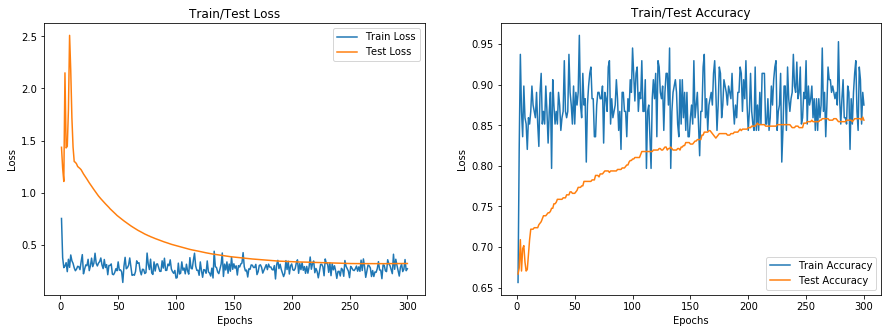

In [7]:
train_loss = mobile_net_history.history['loss']
train_acc = mobile_net_history.history['acc']
test_loss = mobile_net_history.history['val_loss']
test_acc = mobile_net_history.history['val_acc']
epochs = [i for i in range(1, len(test_acc)+1)]

fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].plot(epochs, train_loss, label = 'Train Loss')
ax[0].plot(epochs, test_loss, label = 'Test Loss')
ax[0].set_title('Train/Test Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, train_acc, label = 'Train Accuracy')
ax[1].plot(epochs, test_acc, label = 'Test Accuracy')
ax[1].set_title('Train/Test Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

### ROC and AUC

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


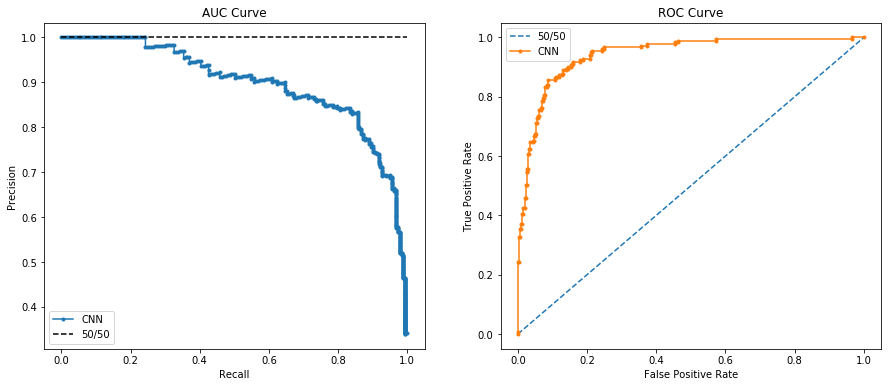

,F1 Score,AUC,ROC
0,0.751,0.897,0.943


In [8]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc

if var.img_type == 'grey': 
    dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 1)
else: 
    dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 3)
    
mobilenet = get_mobile_net(dim)
mobilenet.load_weights('../models/Test_MobileNet-ModelCheckpointWeights.h5') #load the best weights before overfitting
 

fig, ax = plt.subplots(1,2, figsize = (15,6))
#AUC CURVE
y_test_prob = mobilenet.predict(x_test)

y_test_precision, y_test_recall, spec = precision_recall_curve(y_test, y_test_prob)
y_test_predict = np.where(y_test_prob >= .5, 1, 0).ravel()
y_test_f1= f1_score(y_test, y_test_predict)
y_test_auc = auc(y_test_recall, y_test_precision)
no_skill = len(y_test[y_test==1]) / len(y_test)
ax[0].plot(y_test_recall, y_test_precision, marker='.', label='CNN')
ax[0].plot([0, 1], [no_skill, no_skill], linestyle='--', label='50/50', color = 'Black')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_title(f'AUC Curve')
ax[0].legend()

#ROC CURVE
ns_probs = [0 for i in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
y_test_roc = roc_auc_score(y_test, y_test_prob)

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
y_test_fpr, y_test_tpr, threshold = roc_curve(y_test, y_test_prob)
ax[1].plot(ns_fpr, ns_tpr, linestyle='--', label='50/50')
ax[1].plot(y_test_fpr, y_test_tpr, marker='.', label='CNN')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title(f'ROC Curve')
ax[1].legend()
plt.show()

pd.DataFrame({'F1 Score': round(y_test_f1, 3), 'AUC': round(y_test_auc, 3), 'ROC':round(y_test_roc, 3)}, index = [0])

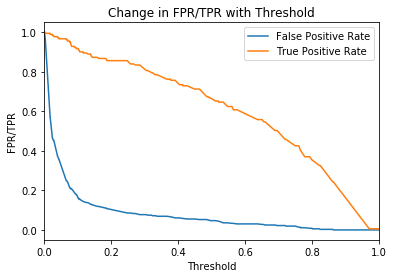

In [9]:
df = pd.DataFrame({'Threshold': threshold, 'FPR': y_test_fpr, 'TPR': y_test_tpr})
plt.plot(df.Threshold, df.FPR, label = 'False Positive Rate')
plt.plot(df.Threshold, df.TPR, label = 'True Positive Rate')
plt.xlabel('Threshold')
plt.ylabel('FPR/TPR')
plt.title('Change in FPR/TPR with Threshold')
plt.xlim(0, 1)
plt.legend()
plt.show()

### Confusion Matrix

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


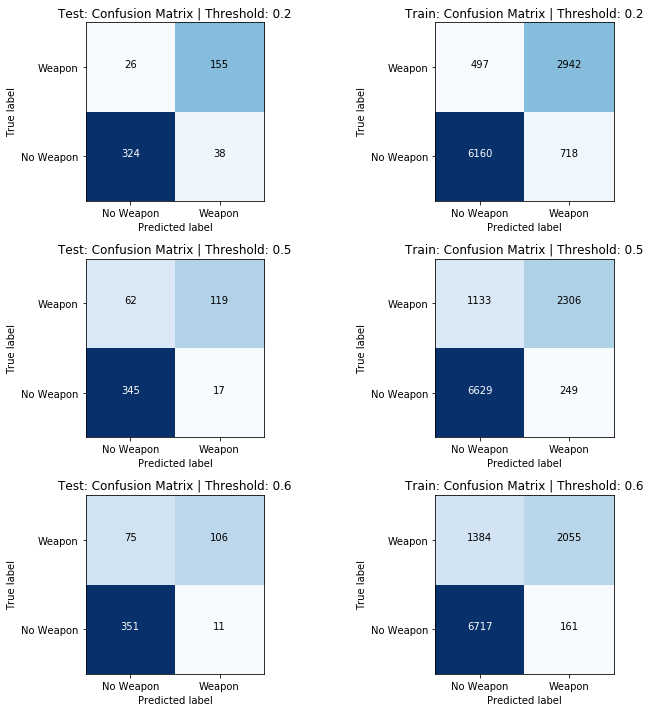

In [10]:
import itertools
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_test,y_train, y_train_prob, y_test_prob,thresholds, classes,
                          cmap=plt.cm.Blues):
    fig, ax = plt.subplots(len(thresholds),2, figsize = (10,10))

    for idx, thresh in enumerate(thresholds):
        y_test_predict = np.where(y_test_prob >= thresh, 1, 0)
        y_train_predict = np.where(y_train_prob >= thresh, 1, 0)
        train_cm = confusion_matrix(y_train, y_train_predict) 
        test_cm = confusion_matrix(y_test, y_test_predict)
        
        #test confusion
        ax[idx, 0].imshow(test_cm,  cmap=plt.cm.Blues) 

        ax[idx, 0].set_title(f'Test: Confusion Matrix | Threshold: {thresh}')
        ax[idx, 0].set_ylabel('True label')
        ax[idx, 0].set_xlabel('Predicted label')

        class_names = classes 
        tick_marks = np.arange(len(class_names))
        ax[idx, 0].set_xticks(tick_marks)
        ax[idx,0].set_xticklabels(class_names)
        ax[idx, 0].set_yticks(tick_marks)
        ax[idx, 0].set_yticklabels(class_names)

        th = test_cm.max() / 2. 

        for i, j in itertools.product(range(test_cm.shape[0]), range(test_cm.shape[1])):
                ax[idx, 0].text(j, i, f'{test_cm[i, j]}',# | {int(round(test_cm[i,j]/test_cm.ravel().sum(),5)*100)}%',
                         horizontalalignment='center',
                         color='white' if test_cm[i, j] > th else 'black')
        ax[idx, 0].set_ylim([-.5,1.5])
        
        #TRAIN CONFUSION
        ax[idx, 1].imshow(train_cm,  cmap=plt.cm.Blues) 

        ax[idx, 1].set_title(f'Train: Confusion Matrix | Threshold: {thresh}')
        ax[idx, 1].set_ylabel('True label')
        ax[idx, 1].set_xlabel('Predicted label')

        class_names = classes 
        tick_marks = np.arange(len(class_names))
        ax[idx, 1].set_xticks(tick_marks)
        ax[idx,1].set_xticklabels(class_names)
        ax[idx, 1].set_yticks(tick_marks)
        ax[idx, 1].set_yticklabels(class_names)


        th = train_cm.max() / 2. 

        for i, j in itertools.product(range(train_cm.shape[0]), range(train_cm.shape[1])):
                ax[idx, 1].text(j, i, f'{train_cm[i, j]}',# | {int(round(train_cm[i,j]/train_cm.ravel().sum(),5)*100)}%',
                         horizontalalignment='center',
                         color='white' if train_cm[i, j] > th else 'black')
        ax[idx, 1].set_ylim([-.5,1.5])
    plt.tight_layout()
 
    plt.show()
if var.img_type == 'grey': 
    dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 1)
else: 
    dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 3)
    
mobilenet = get_mobile_net(dim)
mobilenet.load_weights('../models/Test_MobileNet-ModelCheckpointWeights.h5') #load the best weights before overfitting
 

y_test_prob = mobilenet.predict(x_test).ravel()

y_train_prob = mobilenet.predict(x_train).ravel()

plot_confusion_matrix(y_train = y_train, y_test = y_test, y_train_prob = y_train_prob,
                      y_test_prob = y_test_prob,classes = ['No Weapon', 'Weapon'], thresholds = [.2, .5,.6])

In [11]:
assert False

AssertionError: 

### Test on Google

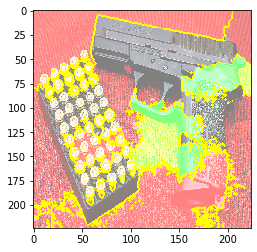

In [35]:
import cv2
from lime import lime_image
from skimage.segmentation import mark_boundaries
import Functions as func

if var.img_type == 'grey': 
    dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 1)
else: 
    dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 3)
    
mobilenet = get_mobile_net(dim)
mobilenet.load_weights('../models/Test_MobileNet-ModelCheckpointWeights.h5') #load the best weights before overfitting
img = func.get_image_value('../test3.jpg', var.mobilenet_dimension, var.img_type)

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(img, mobilenet.predict, top_labels = 5, hide_color = 0, 
                                         num_samples = 1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only = False,
                                           num_features = 10, hide_rest = False)
plt.imshow(mark_boundaries(temp/2 + .5, mask))

In [36]:
img = cv2.imread('../test3.jpg')
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process() 

windows = []
locations = []
for x, y, w,h in rects: 
    startx = x 
    starty = y 
    endx = x+w 
    endy = y+h 
    roi = img[starty:endy, startx:endx]
    roi = cv2.resize(roi, dsize =var.mobilenet_dimension, interpolation = cv2.INTER_CUBIC)
    windows.append(roi)
    locations.append((startx, starty, endx, endy))

    
windows = np.array(windows)

predictions = mobilenet.predict(windows)

In [37]:
clone = img.copy()
new_loc = [] 
new_prob = [] 
for idx, i in enumerate(predictions): 
    if i < .2: 
        continue
    startx, starty, endx, endy = locations[idx]
    cv2.rectangle(clone, (startx, starty), (endx, endy),  (0,255,0),2)
    text = f'Weapon: {i*100}'
    cv2.putText(clone, text, (startx, y), cv2.FONT_HERSHEY_SIMPLEX, .45, (0,255,0),2)
    new_loc.append(locations[idx])
    new_prob.append(i[0])
    
cv2.imshow('test', clone)
cv2.waitKey(0)

-1

In [38]:
predictions.max()

0.6285158

In [39]:
test = np.array(new_prob).ravel()
print(np.argmax(test), test.max())
test

180 0.6285158


array([0.39851093, 0.30220854, 0.39310834, 0.33220118, 0.31042388,
       0.37626612, 0.38817352, 0.3692353 , 0.20191683, 0.38114104,
       0.24939997, 0.22480607, 0.28846785, 0.24164435, 0.27801183,
       0.3645336 , 0.23020175, 0.35136807, 0.23613454, 0.3104145 ,
       0.31095782, 0.3176451 , 0.21881767, 0.36470142, 0.4847334 ,
       0.37241292, 0.24107285, 0.47870237, 0.25301605, 0.23013468,
       0.20174688, 0.21236573, 0.25772354, 0.23661721, 0.35515505,
       0.2154412 , 0.22495659, 0.25886685, 0.20517781, 0.5192301 ,
       0.29793185, 0.20589983, 0.23669209, 0.25045902, 0.28773433,
       0.623089  , 0.2940732 , 0.24987286, 0.26410952, 0.26317716,
       0.25778523, 0.33811852, 0.25553828, 0.2399365 , 0.21472196,
       0.4061954 , 0.22497874, 0.39621866, 0.2311601 , 0.3367105 ,
       0.22325987, 0.47057235, 0.5499763 , 0.31204504, 0.2802379 ,
       0.20327255, 0.21947737, 0.28877962, 0.21121499, 0.24127315,
       0.52626467, 0.31450304, 0.24674827, 0.20461862, 0.21561

In [40]:
print(len(new_loc), len(test))

338 338


In [41]:
boxids = func.non_max_suppression(np.array(new_loc), np.array(new_prob))[0]
clone = img.copy()
  
startx, starty, endx, endy = new_loc[180]
cv2.rectangle(clone, (startx, starty), (endx, endy),  (0,255,0),2)
text = f'Weapon: {i*100}'
cv2.putText(clone, text, (startx, y), cv2.FONT_HERSHEY_SIMPLEX, .45, (0,255,0),2)
cv2.imshow('test', clone)
cv2.waitKey(0)

-1